<a href="https://colab.research.google.com/github/AshishGusain17/colab_notebooks/blob/main/keras_model_load_weight_sequentially.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# keras version: 2.4.0
# tensorflow version: 2.3.0


In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

In [ ]:
# !pip install 'tensorflow==2.3.0'

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, multiply, add, LeakyReLU
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf



from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB5
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import model_from_yaml



import numpy as np
import os
import cv2
import datetime
import shutil
import argparse
import random
import pickle
import h5py
import cv2
import math



import matplotlib
matplotlib.use("Agg")

# creating pre-trained model of EfficientNet B5(except last 15 layers)

In [7]:
temp_model = EfficientNetB5(
    include_top=False,
    weights="imagenet")


print([temp_model.layers[-16].name, temp_model.layers[-19].name])

inter_model_15 = Model(inputs = temp_model.input, 
                     outputs = [temp_model.layers[-16].output, 
                                temp_model.layers[-19].output])

# inter_model_15.summary()
# (1, 14, 14, 3072)
# (1, 14, 14, 512)

# plot_model(inter_model_15, to_file='inter_model_15.png',show_shapes=True)

115269632/115263384 [==============================] - 1s 0us/step
['block7c_expand_activation', 'block7b_add']


# saving the pretrained model

In [9]:
inter_model_15_json = inter_model_15.to_json()
with open("inter_model_15_json.json", "w") as json_file:
    json_file.write(inter_model_15_json)
    
    
    
# serialize weights to HDF5
inter_model_15.save_weights("inter_model_15_weight.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


# confirming the outputs of the pre-trained model

In [15]:
img = cv2.imread('img1.jpg') 
img = cv2.resize(img, (456, 456))
print("Image shape: ", img.shape)
x = np.expand_dims(img, axis=0)



ans1 = inter_model_15.predict(x)
print("\nOutput number of layers: ", len(ans1))

print("\nShapes of all the layers:")
for i in range(len(ans1)):
    print(ans1[i].shape)


Image shape:  (456, 456, 3)

Output number of layers:  2

Shapes of all the layers:
(1, 14, 14, 3072)
(1, 14, 14, 512)


# loading the original trained model along with weights
# model_name = fin_model

In [ ]:
def build_multi_block(inputs):
    x = GlobalAveragePooling2D()(inputs)
    drop = Dropout(0.3)(x)
    x = Dense(256)(drop)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LeakyReLU(alpha=0.3)(x)
    outputs = Dense(13, activation = 'sigmoid')(x)
    
    return outputs




base_model = EfficientNetB5(include_top=False, weights='imagenet')
base_model._name = "eff_model_case4"
base_model.trainable = False 

inputs = Input(shape=(456, 456, 3))
x = base_model(inputs)

output1 = build_multi_block(x)

org_multi_model_15 = Model(inputs = inputs, outputs = output1)





base_model.trainable=True

def unfreeze_model(model):
    for layer in model.layers[:-15]:
        layer.trainable = False 

unfreeze_model(base_model)      






y = org_multi_model_15.layers[-2].output
outputs_y = Dense(1, activation = "sigmoid")(y)
fin_model = Model(org_multi_model_15.input, outputs_y)



base_model.trainable=True

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-5]:
        layer.trainable = False 

unfreeze_model(base_model)



weight_file_path_15_unfreeze = 'weight_file.h5'
fin_model.load_weights(weight_file_path_15_unfreeze)






img = cv2.imread('img1.jpg') 
img = cv2.resize(img, (456, 456))
print(img.shape)

x = np.expand_dims(img, axis=0)
print(fin_model.predict(x))

(456, 456, 3)
[[2.8586383e-17]]


# keras sequential model for last 15 layers of pre-trained model EfficientNet B5 and extra layers added similar to above model
# model_name = multi_model_15

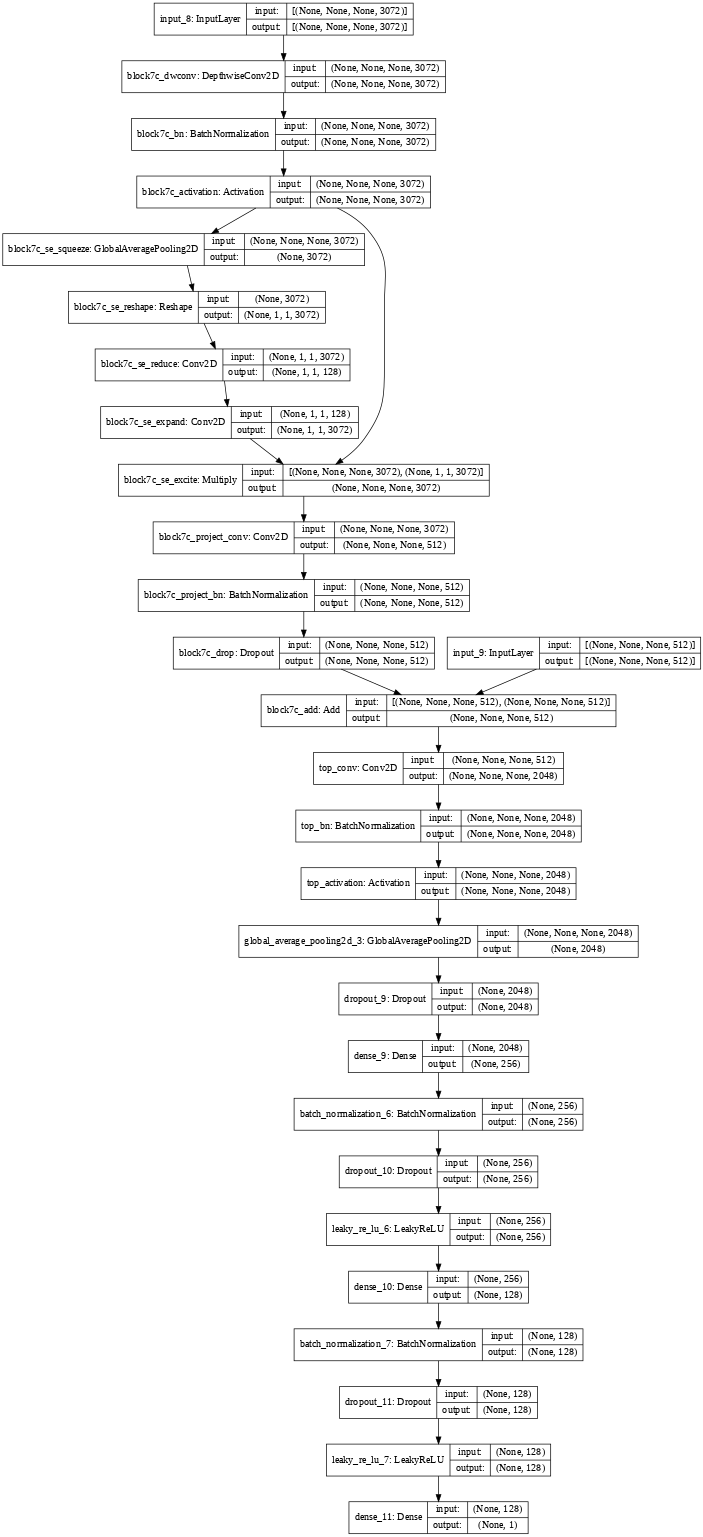

In [19]:
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'truncated_normal'
    }
}

filters_se = 128
activation = "swish"

filters = 3072

filters_out = 512

bn_axis = 3

drop_rate = 0.19487179487179487

depth_divisor = 8
width_coefficient = 1.6




inp1 = Input(shape = (None, None, 3072))
inp2 = Input(shape = (None, None, 512))

kernel_size = 3
strides = 1
conv_pad = 'same'


x = layers.DepthwiseConv2D(
    kernel_size,
    strides=strides,
    padding=conv_pad,
    use_bias=False,
    depthwise_initializer=CONV_KERNEL_INITIALIZER,
    name = 'block7c_dwconv')(inp1)

x = layers.BatchNormalization(axis=bn_axis, name ='block7c_bn')(x)

out1 = layers.Activation(activation, name = 'block7c_activation')(x)

x = layers.GlobalAveragePooling2D(name = 'block7c_se_squeeze')(out1)

x = layers.Reshape((1, 1, filters), name = 'block7c_se_reshape')(x)

x = Conv2D(
    filters_se,
    1,
    padding='same',
    activation=activation,
    kernel_initializer=CONV_KERNEL_INITIALIZER,
    name = 'block7c_se_reduce')(x)
# print(x.get_shape)

x = Conv2D(
    filters,
    1,
    padding='same',
    activation='sigmoid',
    kernel_initializer=CONV_KERNEL_INITIALIZER,
    name = 'block7c_se_expand')(x)

x = multiply([out1, x], name = 'block7c_se_excite')

# Output phase
x = Conv2D(
    filters_out,
    1,
    padding='same',
    use_bias=False,
    kernel_initializer=CONV_KERNEL_INITIALIZER,
    name = 'block7c_project_conv')(x)

x = BatchNormalization(axis=bn_axis, name = 'block7c_project_bn')(x)

x = Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name = 'block7c_drop')(x)

x = add([x, inp2], name = 'block7c_add')



def round_filters(filters, divisor=depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)


# Build top
x = Conv2D(
    round_filters(1280),
    1,
    padding='same',
    use_bias=False,
    kernel_initializer=CONV_KERNEL_INITIALIZER,
    name='top_conv')(x)

x = BatchNormalization(axis=bn_axis, name='top_bn')(x)

x = Activation(activation, name='top_activation')(x)


x = GlobalAveragePooling2D()(x)
drop = Dropout(0.3)(x)
x = Dense(256)(drop)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = LeakyReLU(alpha=0.3)(x)
outputs = Dense(1, activation = 'sigmoid')(x)



multi_model_15 = Model(inputs = [inp1, inp2], outputs = outputs)
plot_model(multi_model_15, to_file='multi_model_15.png',show_shapes=True, dpi = 50)

# fin_model and multi_model_15 will have same layer names initially(similar to EfficientNet B5) and after that their layer names will differ

In [ ]:
for j in range(11, 0, -1):
    print(fin_model.layers[-j].name, "     ", multi_model_15.layers[-j].name)

global_average_pooling2d_2       global_average_pooling2d_3
dropout_6       dropout_9
dense_6       dense_10
batch_normalization_4       batch_normalization_6
dropout_7       dropout_10
leaky_re_lu_4       leaky_re_lu_6
dense_7       dense_11
batch_normalization_5       batch_normalization_7
dropout_8       dropout_11
leaky_re_lu_5       leaky_re_lu_7
dense_9       dense_12


# Copying weights from fin_model to multi_model_15     
### Case 1: When the layer names are same, we will copy weights using layer names
### Case 2: When layer names are different, we will copy weights using their indices

In [ ]:
# Case 1:
for i in fin_model.get_layer("eff_model_case4").layers[-15:]:
    multi_model_15.get_layer(i.name).set_weights(i.get_weights())
    
    
#     org_multi_model_15.layers[-j].name, "     ", multi_model_15.layers[-j].name)
# bin_model.get_layer(bin_model.layers[-2].name).set_weights(model1.layers[-2].get_weights())



# Case 2:
for j in range(11, 0, -1):
    multi_model_15.layers[-j].set_weights(fin_model.layers[-j].get_weights())

# prediction using keras model created in which we just loaded the weights one by one

In [21]:
img = cv2.imread('img1.jpg') 
img = cv2.resize(img, (456, 456))
print("Image shape: ", img.shape)
x = np.expand_dims(img, axis=0)



ans1 = inter_model_15.predict(x)
print("\nOutput number of layers: ", len(ans1))

print("\nShapes of all the layers:")
for i in range(len(ans1)):
    print(ans1[i].shape)


answer = multi_model_15.predict(ans1)
answer

Image shape:  (456, 456, 3)

Output number of layers:  2

Shapes of all the layers:
(1, 14, 14, 3072)
(1, 14, 14, 512)


array([[0.43364015]], dtype=float32)

# saving the keras model

In [ ]:
multi_model_15_json = multi_model_15.to_json()
with open("model_weights/multi_model_15_layers_1_case_4_json.json", "w") as json_file:
    json_file.write(multi_model_15_json)
    
    
# serialize weights to HDF5
multi_model_15.save_weights("model_weights/multi_model_15_layers_1_case_4_weight.h5")
print("Saved model to disk")

Saved model to disk
